In [1]:
options(warn = -1, tidyverse.quiet = T)

suppressPackageStartupMessages(library(tidyverse, warn.conflicts = F, quietly = T))
suppressPackageStartupMessages(library(cowplot, warn.conflicts = F, quietly = T))
suppressPackageStartupMessages(library(arrow, warn.conflicts = F, quietly = T))

options(readr.show_col_types = FALSE)

# Load data

In [2]:
do_maxgcp_comparison <- function(directory) {
    pcov <- read_tsv(directory + "/pcov/liability.tsv", show_col_types = F, name_repair = "unique_quiet") %>%
        rename(phenotype1 = `...1`) %>%
        column_to_rownames("phenotype1") %>%
        as.matrix
    
    gcov <- read_tsv(directory + "/gcov/g_0.0.tsv", show_col_types = F, name_repair = "unique_quiet") %>%
        rename(phenotype1 = `...1`) %>%
        column_to_rownames("phenotype1") %>%
        as.matrix
    
    pcov_fit <- read_tsv(directory + "/pcov/binary_m_0.05.tsv", show_col_types = F, name_repair = "unique_quiet") %>%
        rename(phenotype1 = `...1`) %>%
        column_to_rownames("phenotype1") %>%
        as.matrix
    
    noisy_gcov <- read_tsv(directory + "/gcov/g_0.05.tsv", show_col_types = F, name_repair = "unique_quiet") %>%
        rename(phenotype1 = `...1`) %>%
        column_to_rownames("phenotype1") %>%
        as.matrix
    
    original_h2 <- diag(gcov) / diag(pcov)
    
    beta <- solve(pcov_fit, gcov)
    beta <- sweep(beta, 2, FUN = "/", STATS = sqrt(diag(t(beta) %*% pcov %*% beta)))
    maxgcp_coher <- colSums(gcov * beta) / sqrt(diag(pcov))
    maxgcp_rg <- colSums(gcov * beta) / sqrt(diag(gcov) * diag(t(beta) %*% gcov %*% beta))
    maxgcp_h2 <- diag(t(beta) %*% gcov %*% beta) / diag(t(beta) %*% pcov %*% beta)
    
    beta_noisy <- solve(pcov_fit, noisy_gcov)
    beta_noisy <- sweep(beta_noisy, 2, FUN = "/", STATS = sqrt(diag(t(beta_noisy) %*% pcov %*% beta_noisy)))
    maxgcp_coher_noisy <- colSums(gcov * beta_noisy) / sqrt(diag(pcov))
    maxgcp_rg_noisy <- colSums(gcov * beta_noisy) / sqrt(diag(gcov) * diag(t(beta_noisy) %*% gcov %*% beta_noisy))
    maxgcp_h2_noisy <- diag(t(beta_noisy) %*% gcov %*% beta_noisy) / diag(t(beta_noisy) %*% pcov %*% beta_noisy)

    bind_rows(
            original_h2 %>% enframe %>% mutate(method = "Naive", metric = "Heritability"),
            maxgcp_coher_noisy %>% enframe %>% mutate(method = "MaxGCP (noisy)", metric = "Co-heritability"),
            maxgcp_rg_noisy %>% enframe %>% mutate(method = "MaxGCP (noisy)", metric = "Genetic correlation"),
            maxgcp_h2_noisy %>% enframe %>% mutate(method = "MaxGCP (noisy)", metric = "Heritability"),
            maxgcp_coher %>% enframe %>% mutate(method = "MaxGCP (optimal)", metric = "Co-heritability"),
            maxgcp_rg %>% enframe %>% mutate(method = "MaxGCP (optimal)", metric = "Genetic correlation"),
            maxgcp_h2 %>% enframe %>% mutate(method = "MaxGCP (optimal)", metric = "Heritability"),
        ) %>%
        mutate(
            simulation = directory %>% str_extract("(?<=sim_)[0-9]+"),
            method = method %>% fct_inorder
        )
}

In [3]:
type_string <- "*sim_*_h_0.1_s_0.5_p_0.0"

maxgcp_comparison_df <- fs::dir_ls("data/simulations/", glob = type_string) %>%
    map(do_maxgcp_comparison) %>%
    list_rbind

maxgcp_comparison_df %>% write_parquet("plot_data/maxgcp-fit-coheritability.parquet")

maxgcp_comparison_df %>% head(2)

name,value,method,metric,simulation
<chr>,<dbl>,<fct>,<chr>,<chr>
Trait_01,0.2348306,Naive,Heritability,100
Trait_02,0.1046723,Naive,Heritability,100


# Plot

In [2]:
maxgcp_comparison_df <- read_parquet("plot_data/maxgcp-fit-coheritability.parquet")

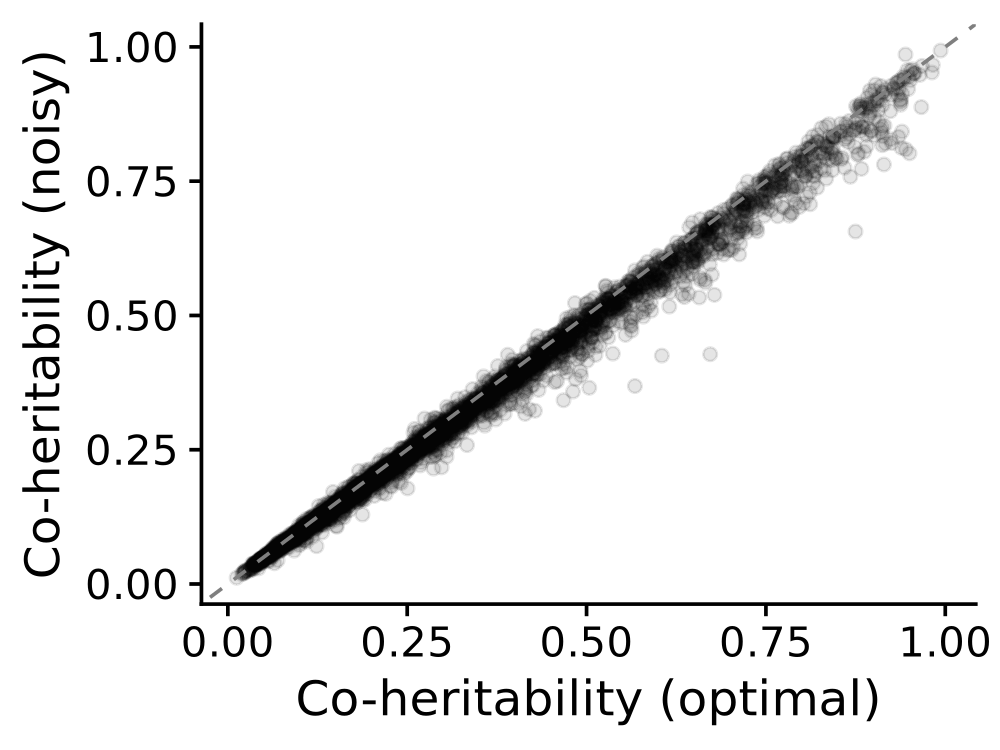

In [3]:
options(repr.plot.width = 4, repr.plot.height = 3, repr.plot.res = 250)

optimal_vs_noisy_plot <- maxgcp_comparison_df %>%
    filter(metric == "Co-heritability") %>%
    pivot_wider(names_from = method, values_from = value) %>%
    ggplot(aes(x = `MaxGCP (optimal)`, y = `MaxGCP (noisy)`)) +
    geom_point(alpha = 0.1) +
    geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "grey50") +
    theme_cowplot() +
    xlab("Co-heritability (optimal)") +
    ylab("Co-heritability (noisy)")

optimal_vs_noisy_plot

In [4]:
plot_df <- bind_rows(
        maxgcp_comparison_df %>%
            filter(method == "Naive", metric == "Heritability") %>%
            mutate(metric = "Co-heritability"),
        maxgcp_comparison_df %>%
            filter(metric == "Co-heritability"),
        maxgcp_comparison_df %>%
            filter(method == "Naive", metric == "Heritability") %>%
            mutate(
                value = abs(1 - value),
                metric = "Genetic loss",
            ),
        maxgcp_comparison_df %>%
            filter(method != "Naive") %>%
            pivot_wider(names_from = metric) %>%
            mutate(
                value = abs(1 - Heritability) + abs(1 - `Genetic correlation`),
                metric = "Genetic loss",
            ) %>%
            select(name, value, method, metric, simulation)
    )

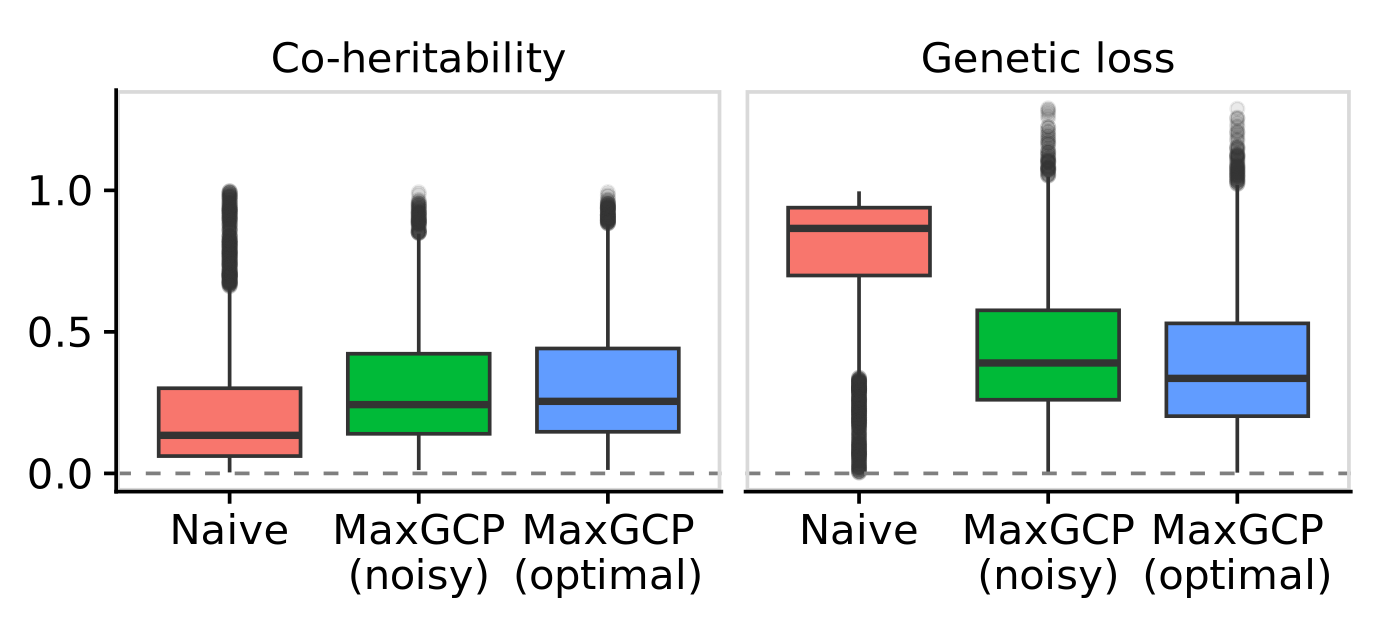

In [5]:
options(repr.plot.width = 5.5, repr.plot.height = 2.5, repr.plot.res = 250)

dual_plot <- plot_df %>%
    ggplot(aes(x = method, y = value, fill = method)) +
    geom_boxplot(outlier.alpha = 0.1) +
    geom_hline(yintercept = c(0), linetype = "dashed", color = "grey50") +
    facet_wrap(vars(metric)) +
    theme_cowplot() +
    theme(
        axis.title = element_blank(),
        legend.position = "none",
        strip.background = element_blank(),
    ) +
    scale_x_discrete(labels = scales::wrap_format(10)) +
    panel_border()

save_plot("img/maxgcp-coheritability-comparison.png", dual_plot, base_width = 5.5, base_height = 3, 
          dpi = 400, bg = "white")

dual_plot